In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use(['science','ieee', 'no-latex']) # set the style of the plots

from util import *

# Logistic Regression

In [2]:
logReg = pd.read_pickle('data/logistic_results.pkl')
logReg['cvResults'] = logReg['cvResults'].transform(pd.DataFrame)
logReg

,numCat,nDims,testMetrics,cvResults,searchObj
0,3,27,"{'accuracy': 0.7454087586757571, 'precision': ...",mean_fit_time std_fit_time mean_score_ti...,"RandomizedSearchCV(cv=4,\n e..."
1,5,41,"{'accuracy': 0.7374239911553344, 'precision': ...",mean_fit_time std_fit_time mean_score_ti...,"RandomizedSearchCV(cv=4,\n e..."
2,10,63,"{'accuracy': 0.7941158405503348, 'precision': ...",mean_fit_time std_fit_time mean_score_ti...,"RandomizedSearchCV(cv=4,\n e..."
3,20,84,"{'accuracy': 0.8041275105951723, 'precision': ...",mean_fit_time std_fit_time mean_score_ti...,"RandomizedSearchCV(cv=4,\n e..."
4,42,105,"{'accuracy': 0.8052330937903077, 'precision': ...",mean_fit_time std_fit_time mean_score_ti...,"RandomizedSearchCV(cv=4,\n e..."


In [3]:
metrics = logReg.testMetrics.iloc[0].keys() # get the metrics

for metric in metrics:
    logReg['bestTest'+metric.capitalize()] = [d[metric] for d in logReg.testMetrics]
logReg.drop(columns=['testMetrics'], inplace=True)

logReg['bestParams'] = logReg['searchObj'].transform(lambda x: x.best_params_)
params = logReg.bestParams.iloc[0].keys()

for param in params:
    logReg['best'+param.capitalize()] = [d[param] for d in logReg.bestParams]
logReg.drop(columns=['bestParams', 'cvResults', 'searchObj'], inplace=True)
logReg

,numCat,nDims,bestTestAccuracy,bestTestPrecision,bestTestRecall,bestTestF1,bestTestRoc_auc,bestPenalty,bestL1_ratio,bestC
0,3,27,0.745409,0.478286,0.856214,0.613736,0.869593,l2,0.1,1.0
1,5,41,0.737424,0.470757,0.897816,0.617655,0.883414,elasticnet,0.7,1.0
2,10,63,0.794116,0.541277,0.842174,0.659003,0.898919,l1,0.1,1.0
3,20,84,0.804128,0.556183,0.845554,0.671000,0.903913,l2,0.0,1.0
4,42,105,0.805233,0.558060,0.843474,0.671705,0.904055,l2,1.0,10.0


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


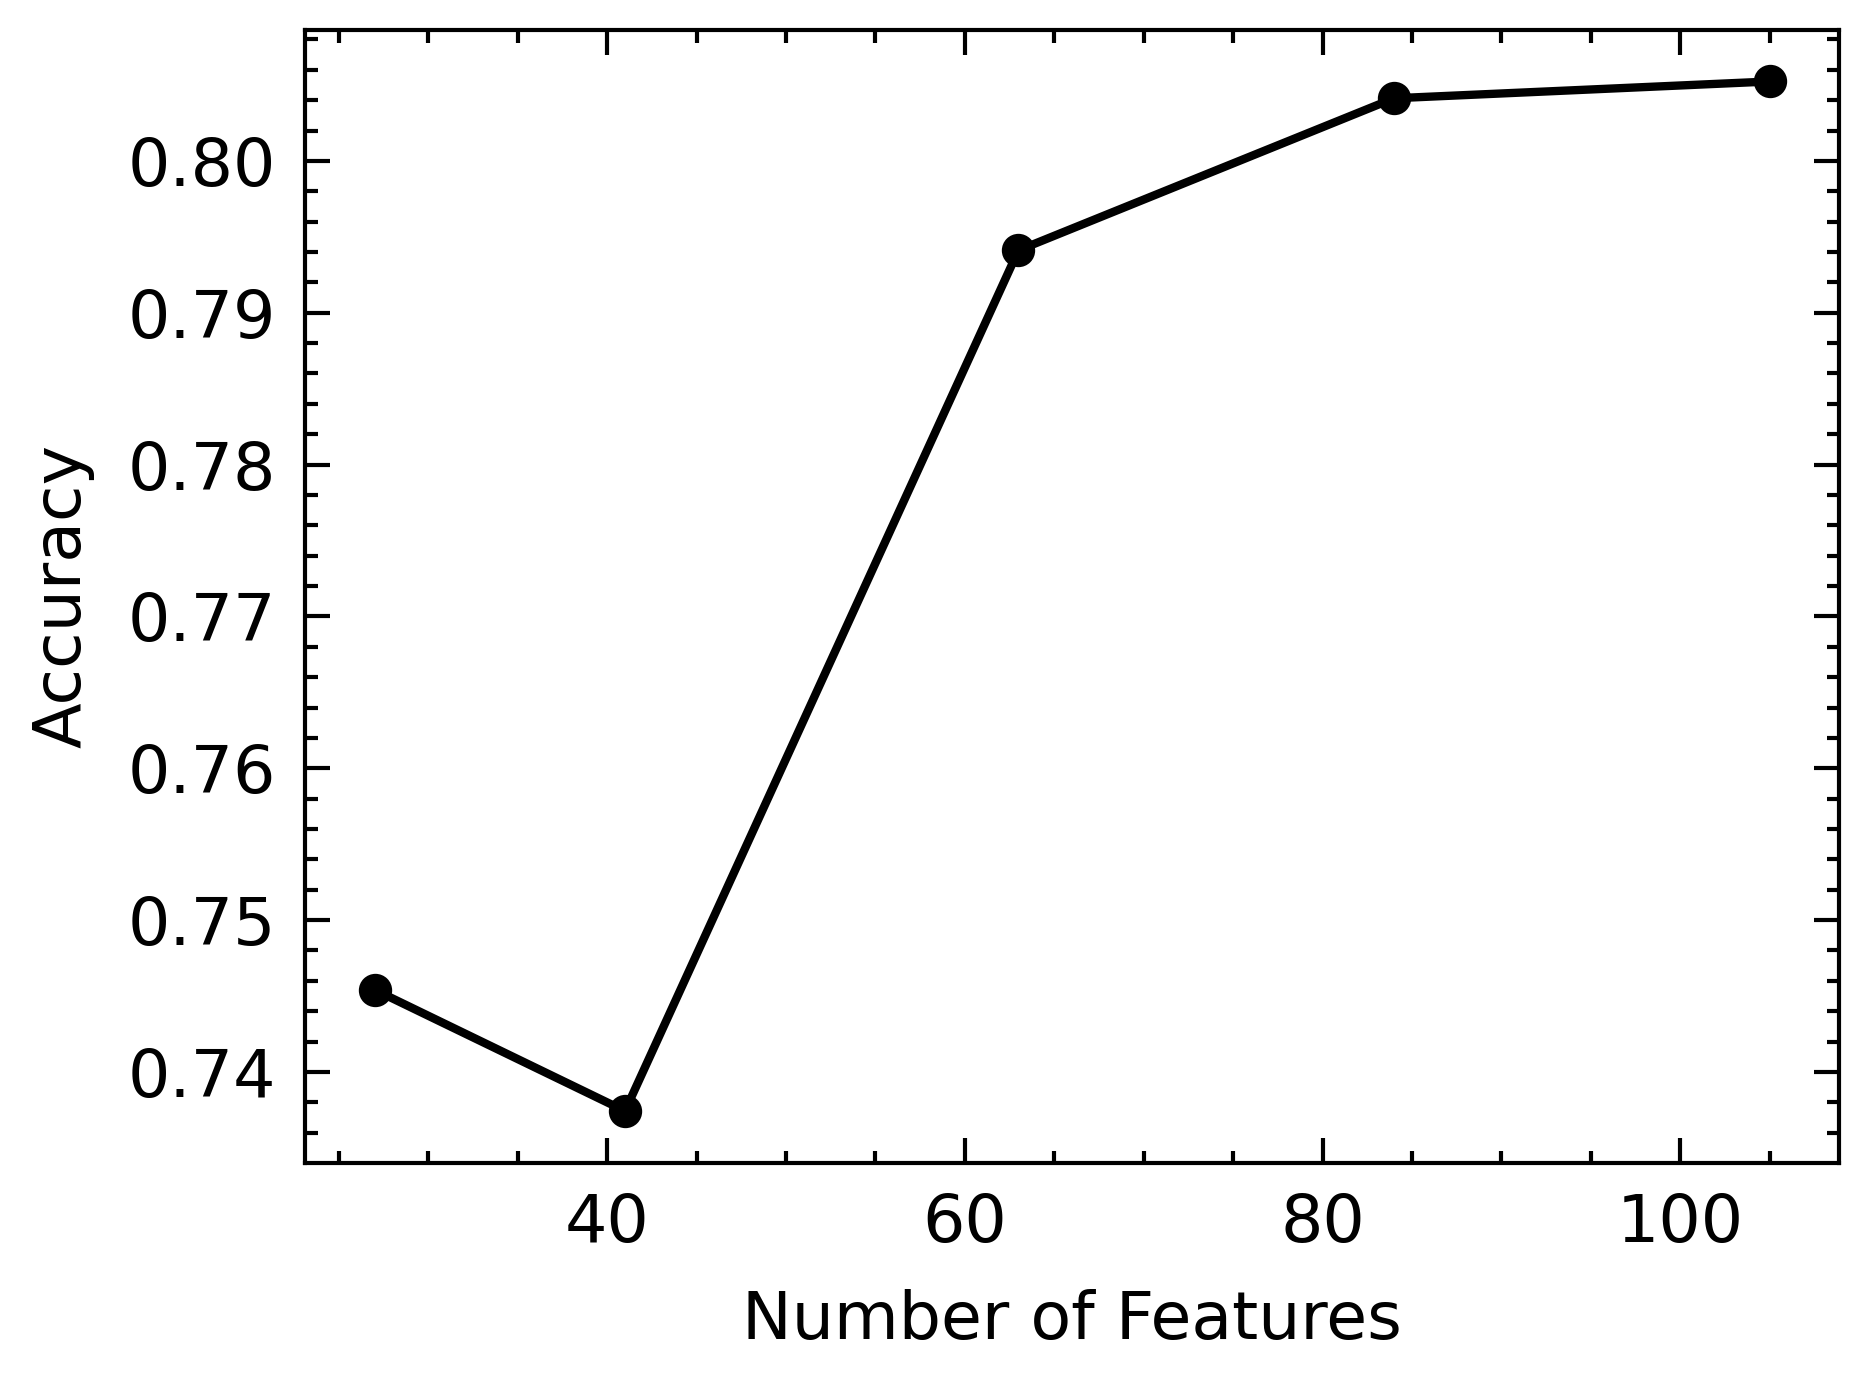

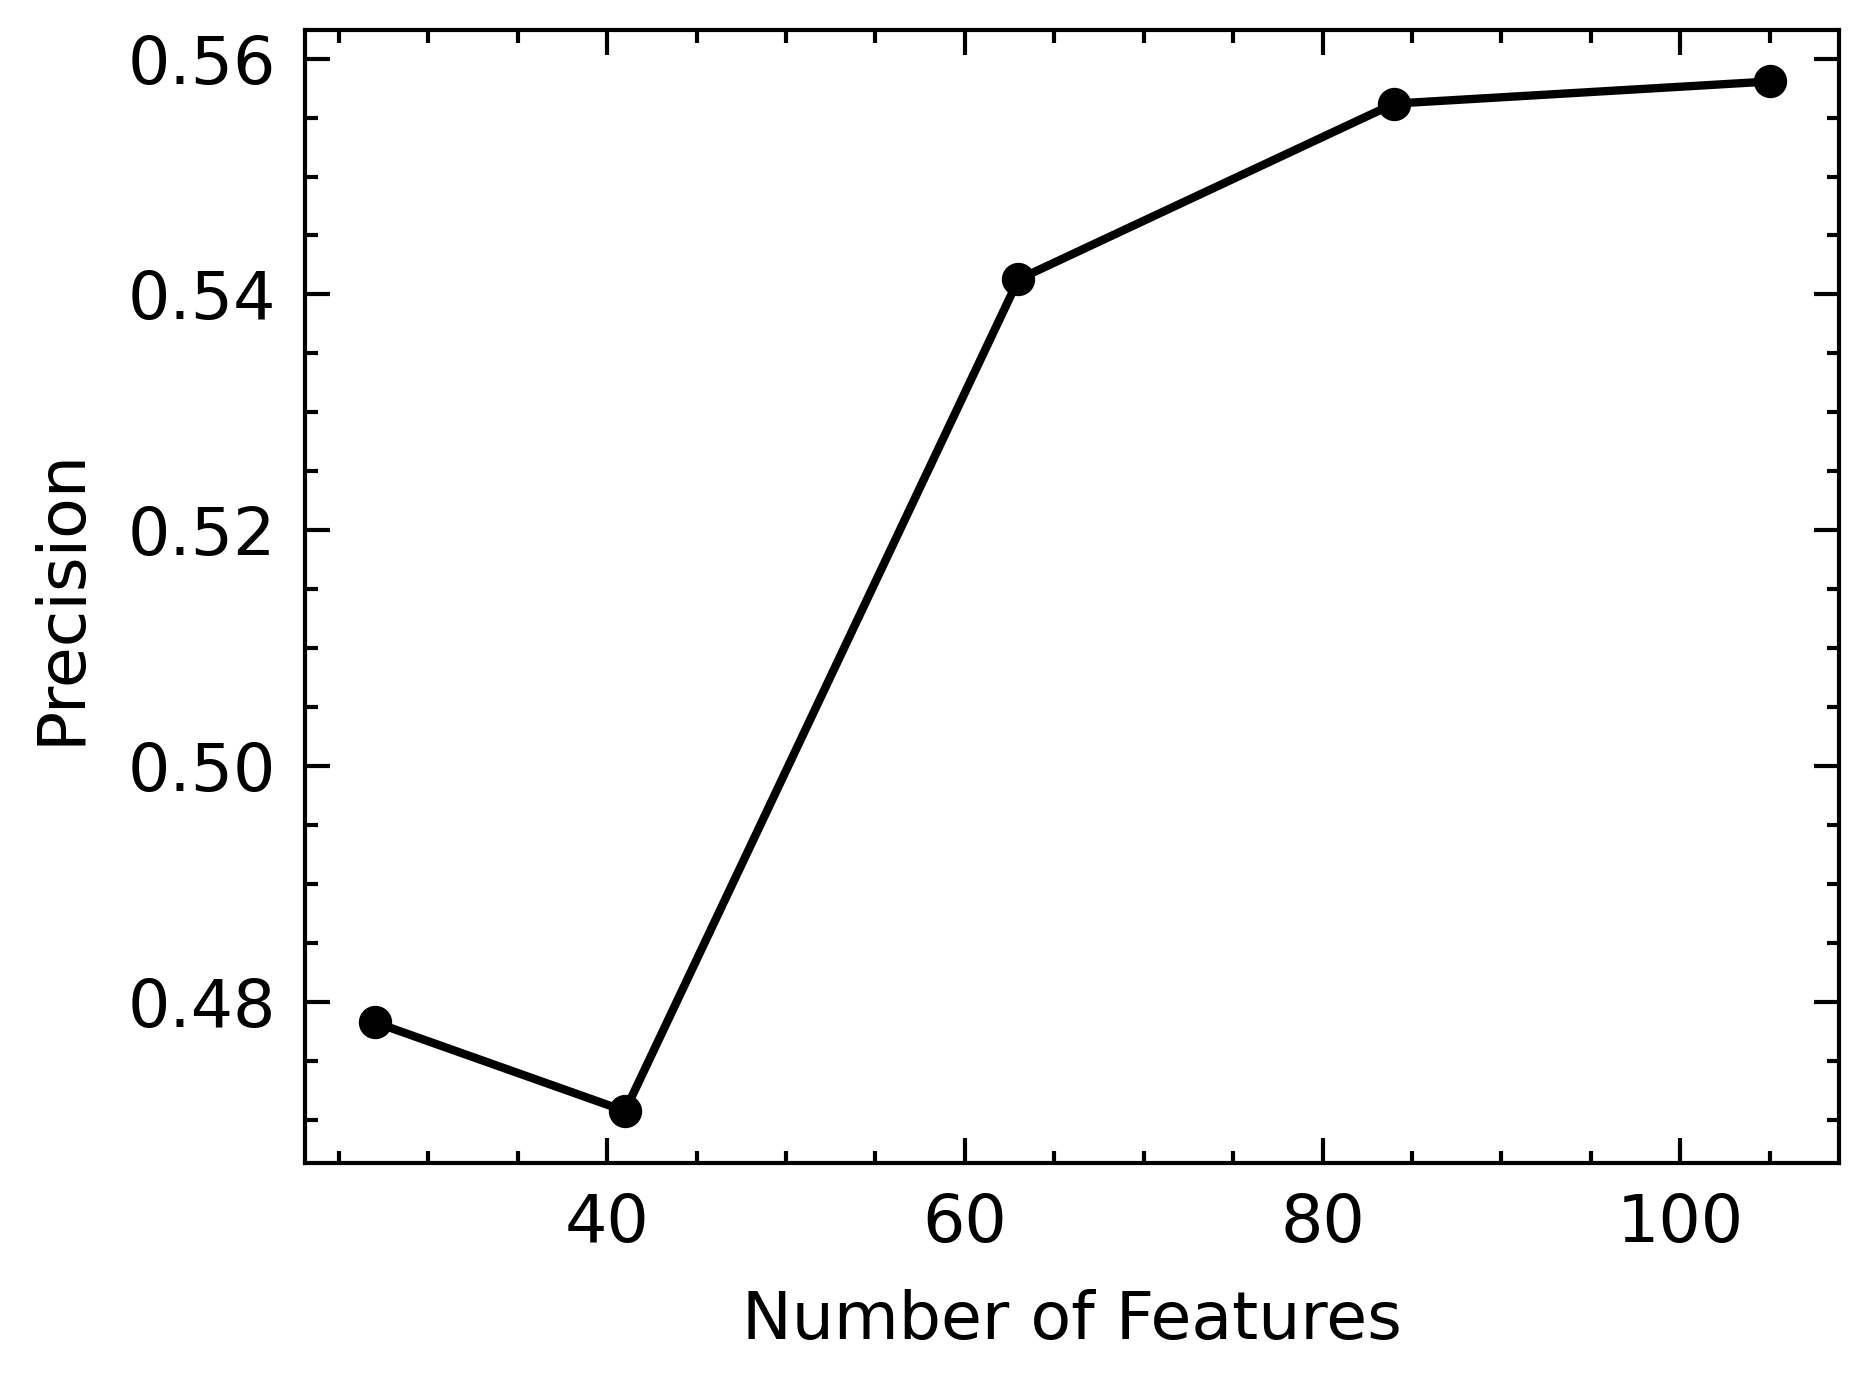

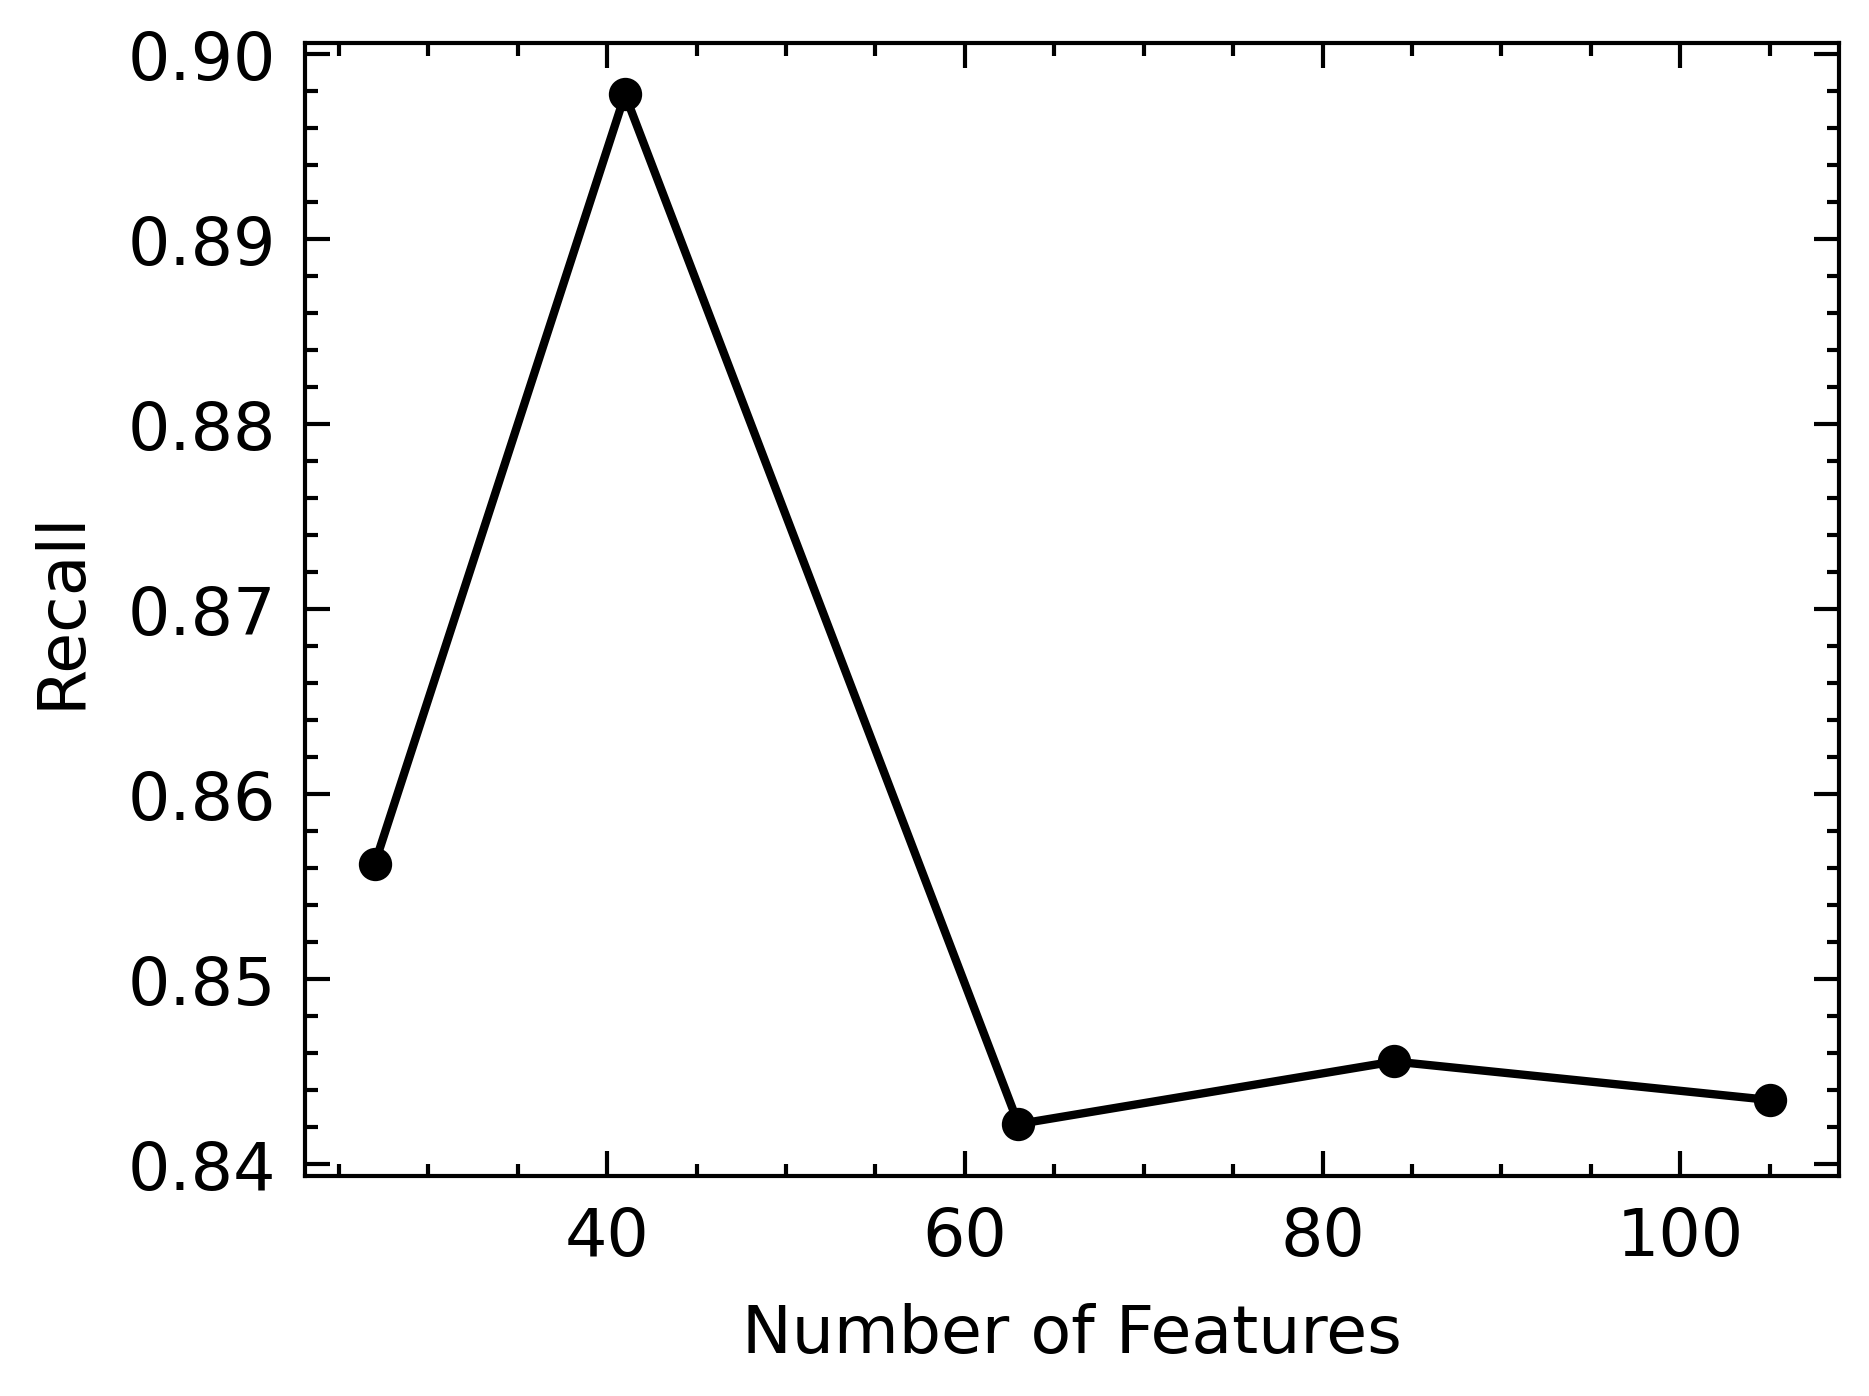

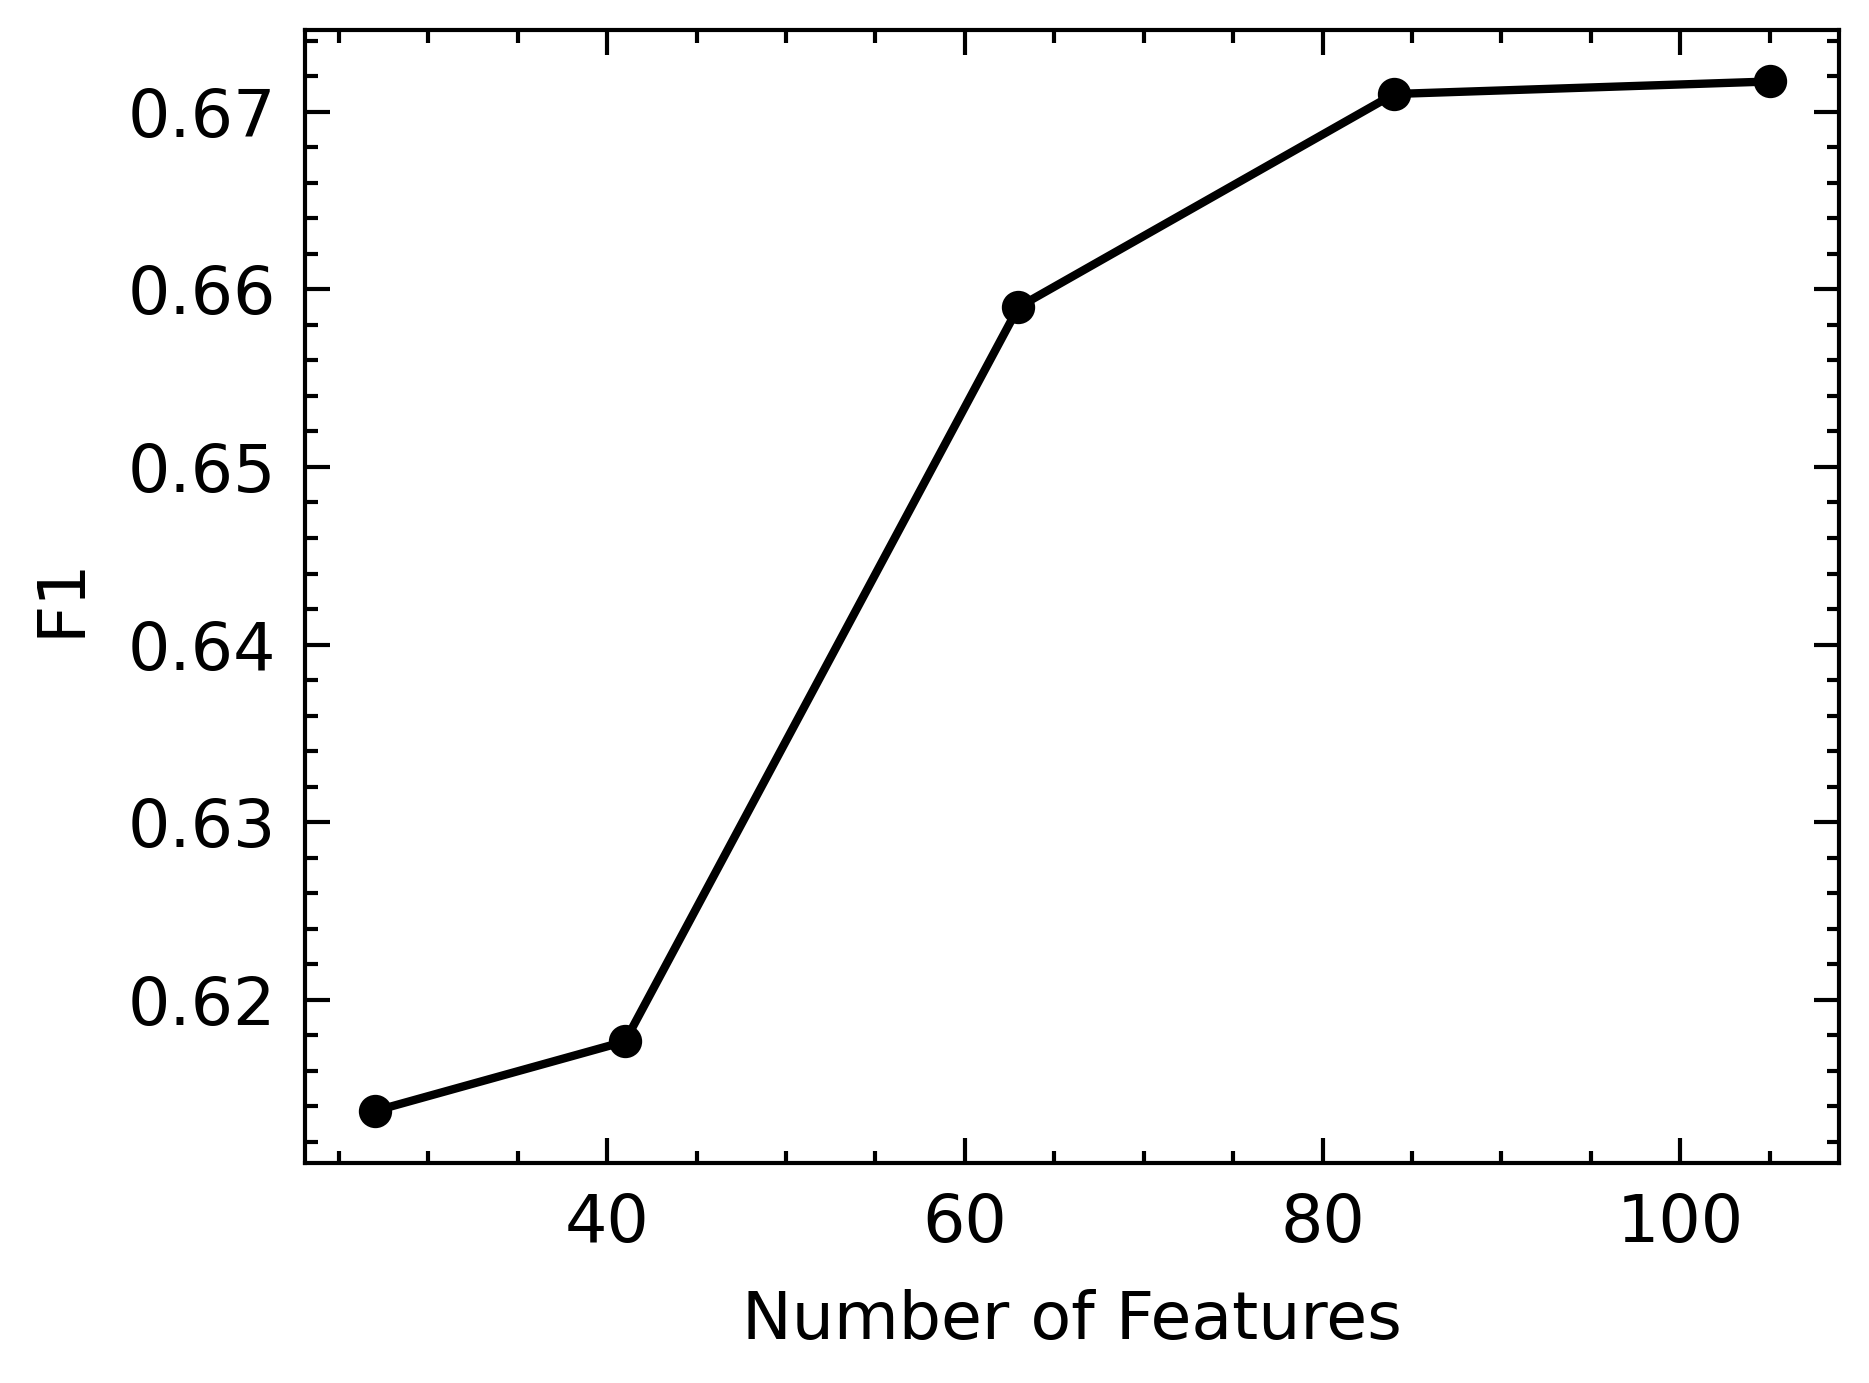

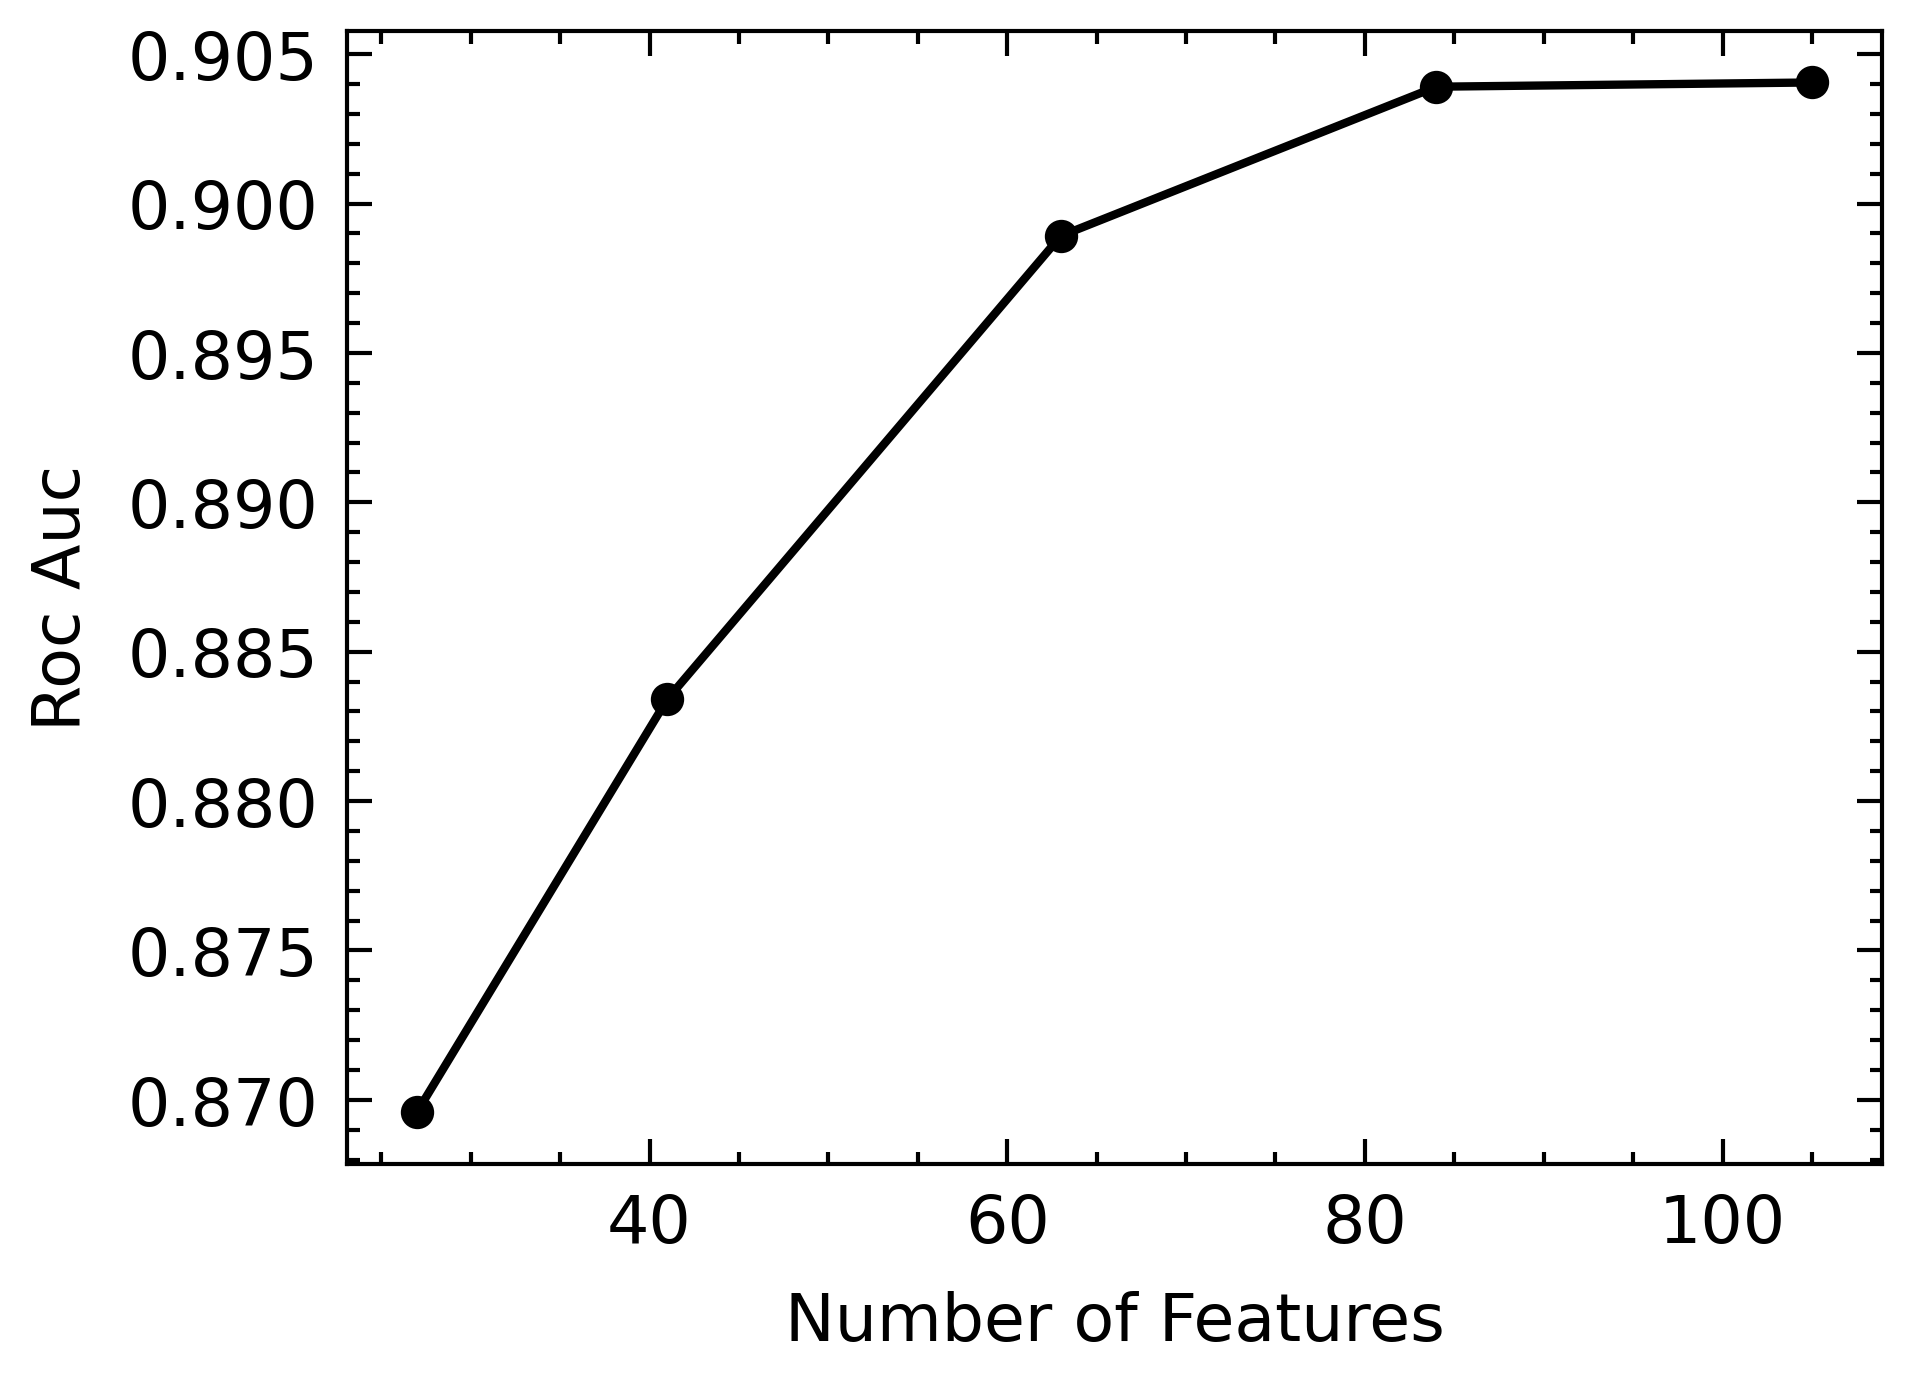

In [4]:
# plot nDims vs all metrics
for metric in metrics:
    metricPrint = metric.replace('_', ' ').title()
    fig, ax = plt.subplots()
    ax.plot(logReg.nDims, logReg['bestTest'+metric.capitalize()], 'o-', markersize=3)
    ax.set_xlabel('Number of Features')
    ax.set_ylabel(metricPrint)
    plt.savefig(f'figures/LogisticRegression/nDimsVs{metricPrint}.png', bbox_inches='tight')
    plt.show()

In [13]:
# Best estimator is the one with the most features
bestEst = pd.read_pickle('data/logistic_results.pkl').iloc[-1].searchObj.best_estimator_
bestEst

LogisticRegression(C=10.0, l1_ratio=1.0, max_iter=300, solver='saga')

In [23]:
adult = pd.read_parquet('data/formatted_data.parquet')
adult.drop(columns=['fnlwgt', 'education-num'], inplace=True) # dropping these columns
train = adult[adult['set'] == 'train'].drop(columns=['set'])
test = adult[adult['set'] == 'test'].drop(columns=['set'])

train_ = dfCategoryLimit(train, 42)
XTrain, YTrain, XTest, YTest = XYSplit(train_, test)
XTrain, YTrain = donwSampleLabels(XTrain, YTrain)

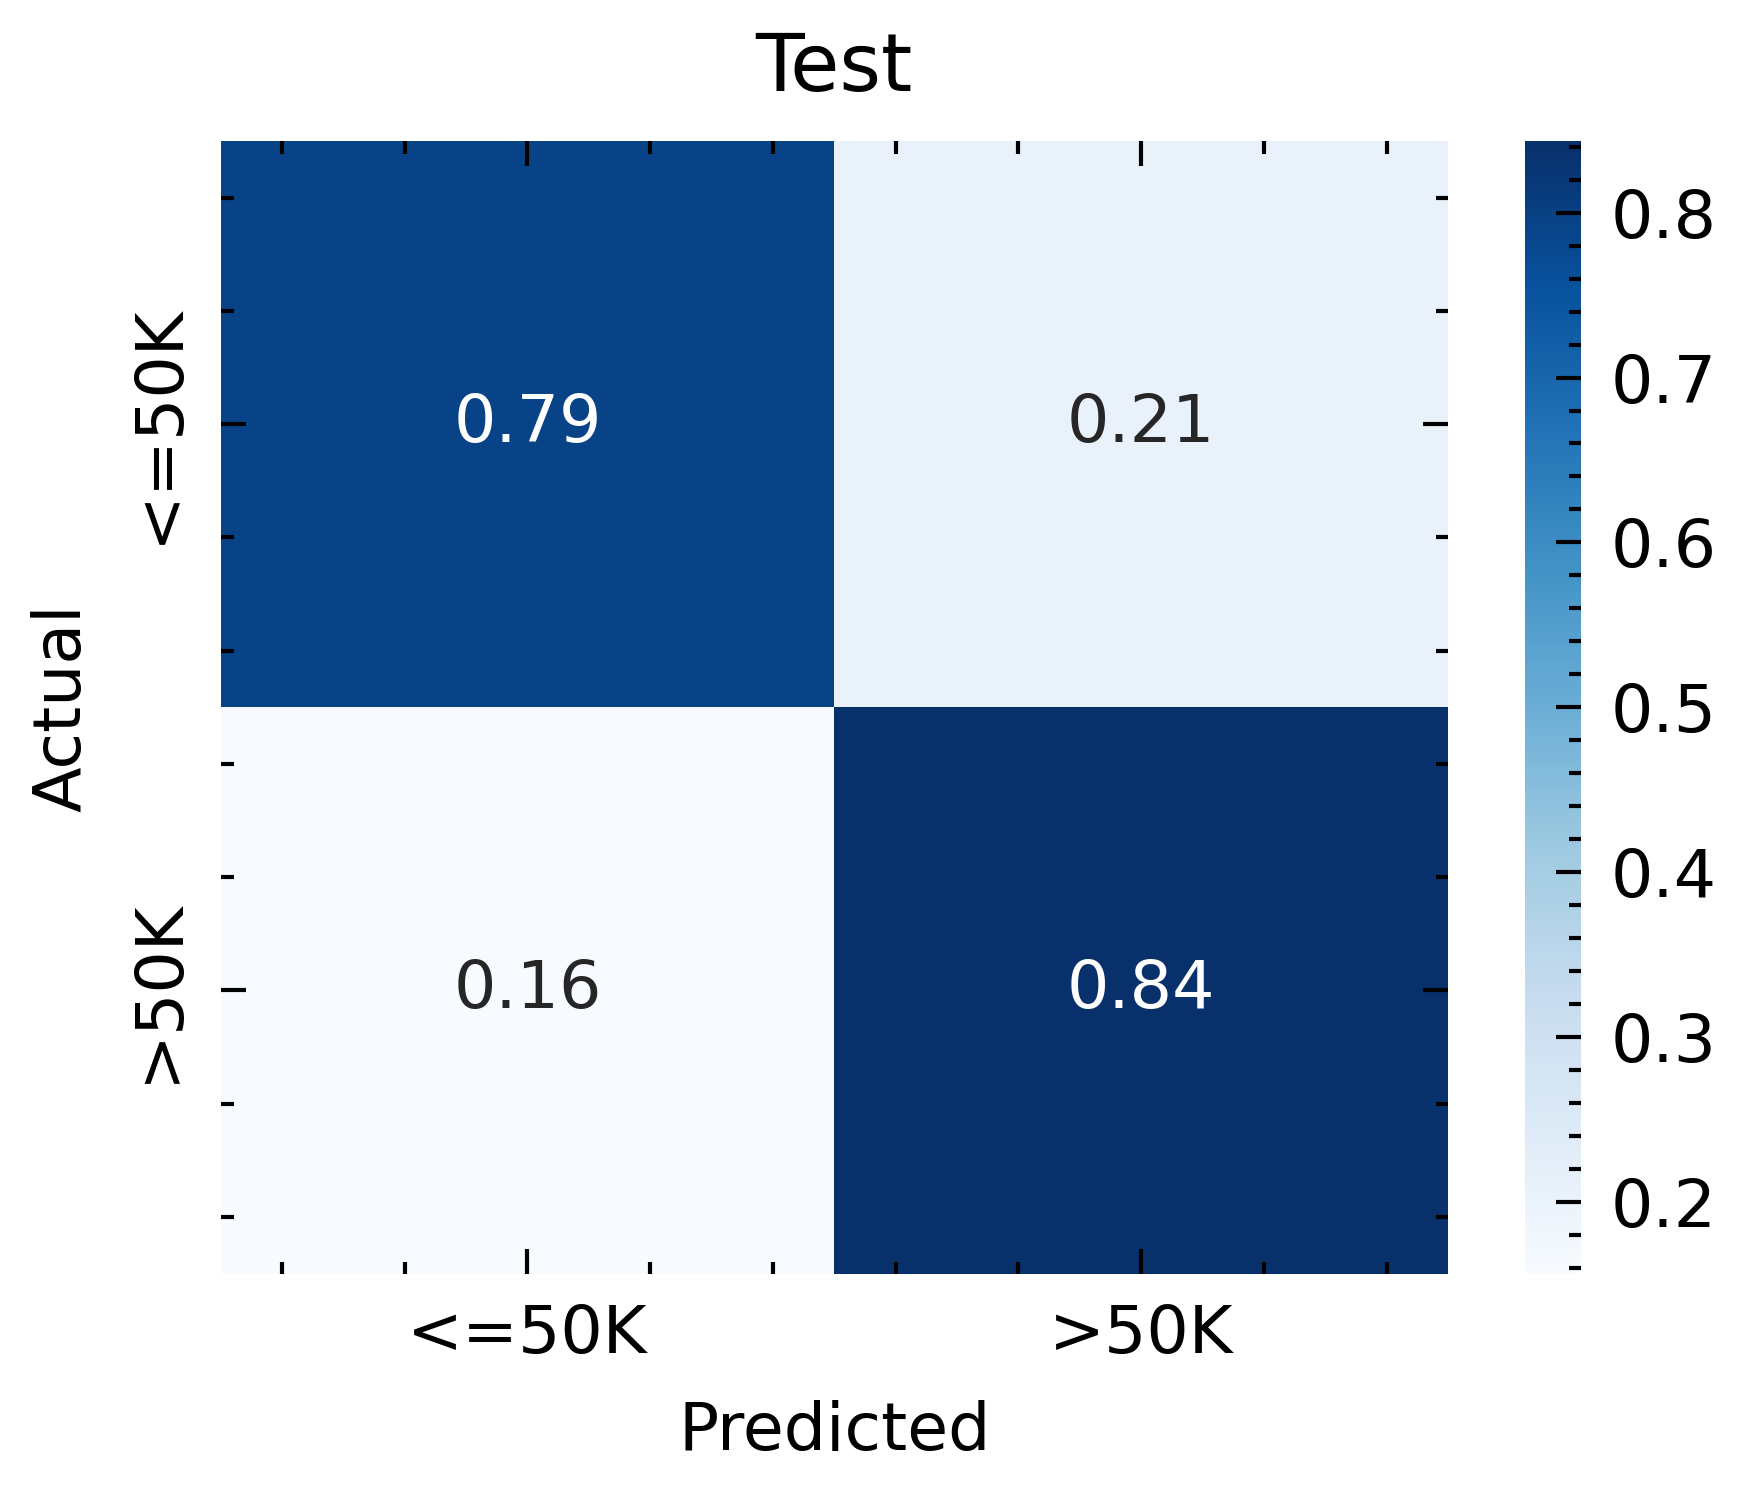

In [53]:
preprocessor = getPreprocessor().fit(XTrain) # fit the preprocessor
XTrainTrans = preprocessor.transform(XTrain) # transform the training data
XTestTrans = preprocessor.transform(XTest) # transform the test data

YTestPred = bestEst.predict(XTestTrans)
YTrainPred = bestEst.predict(XTrainTrans)

# plot the confusion matrix
plotConfusionMatrix(YTest, YTestPred, labels=['<=50K', '>50K'], title='Test', savePath='figures/LogisticRegression/TestConfusionMatrix.png')

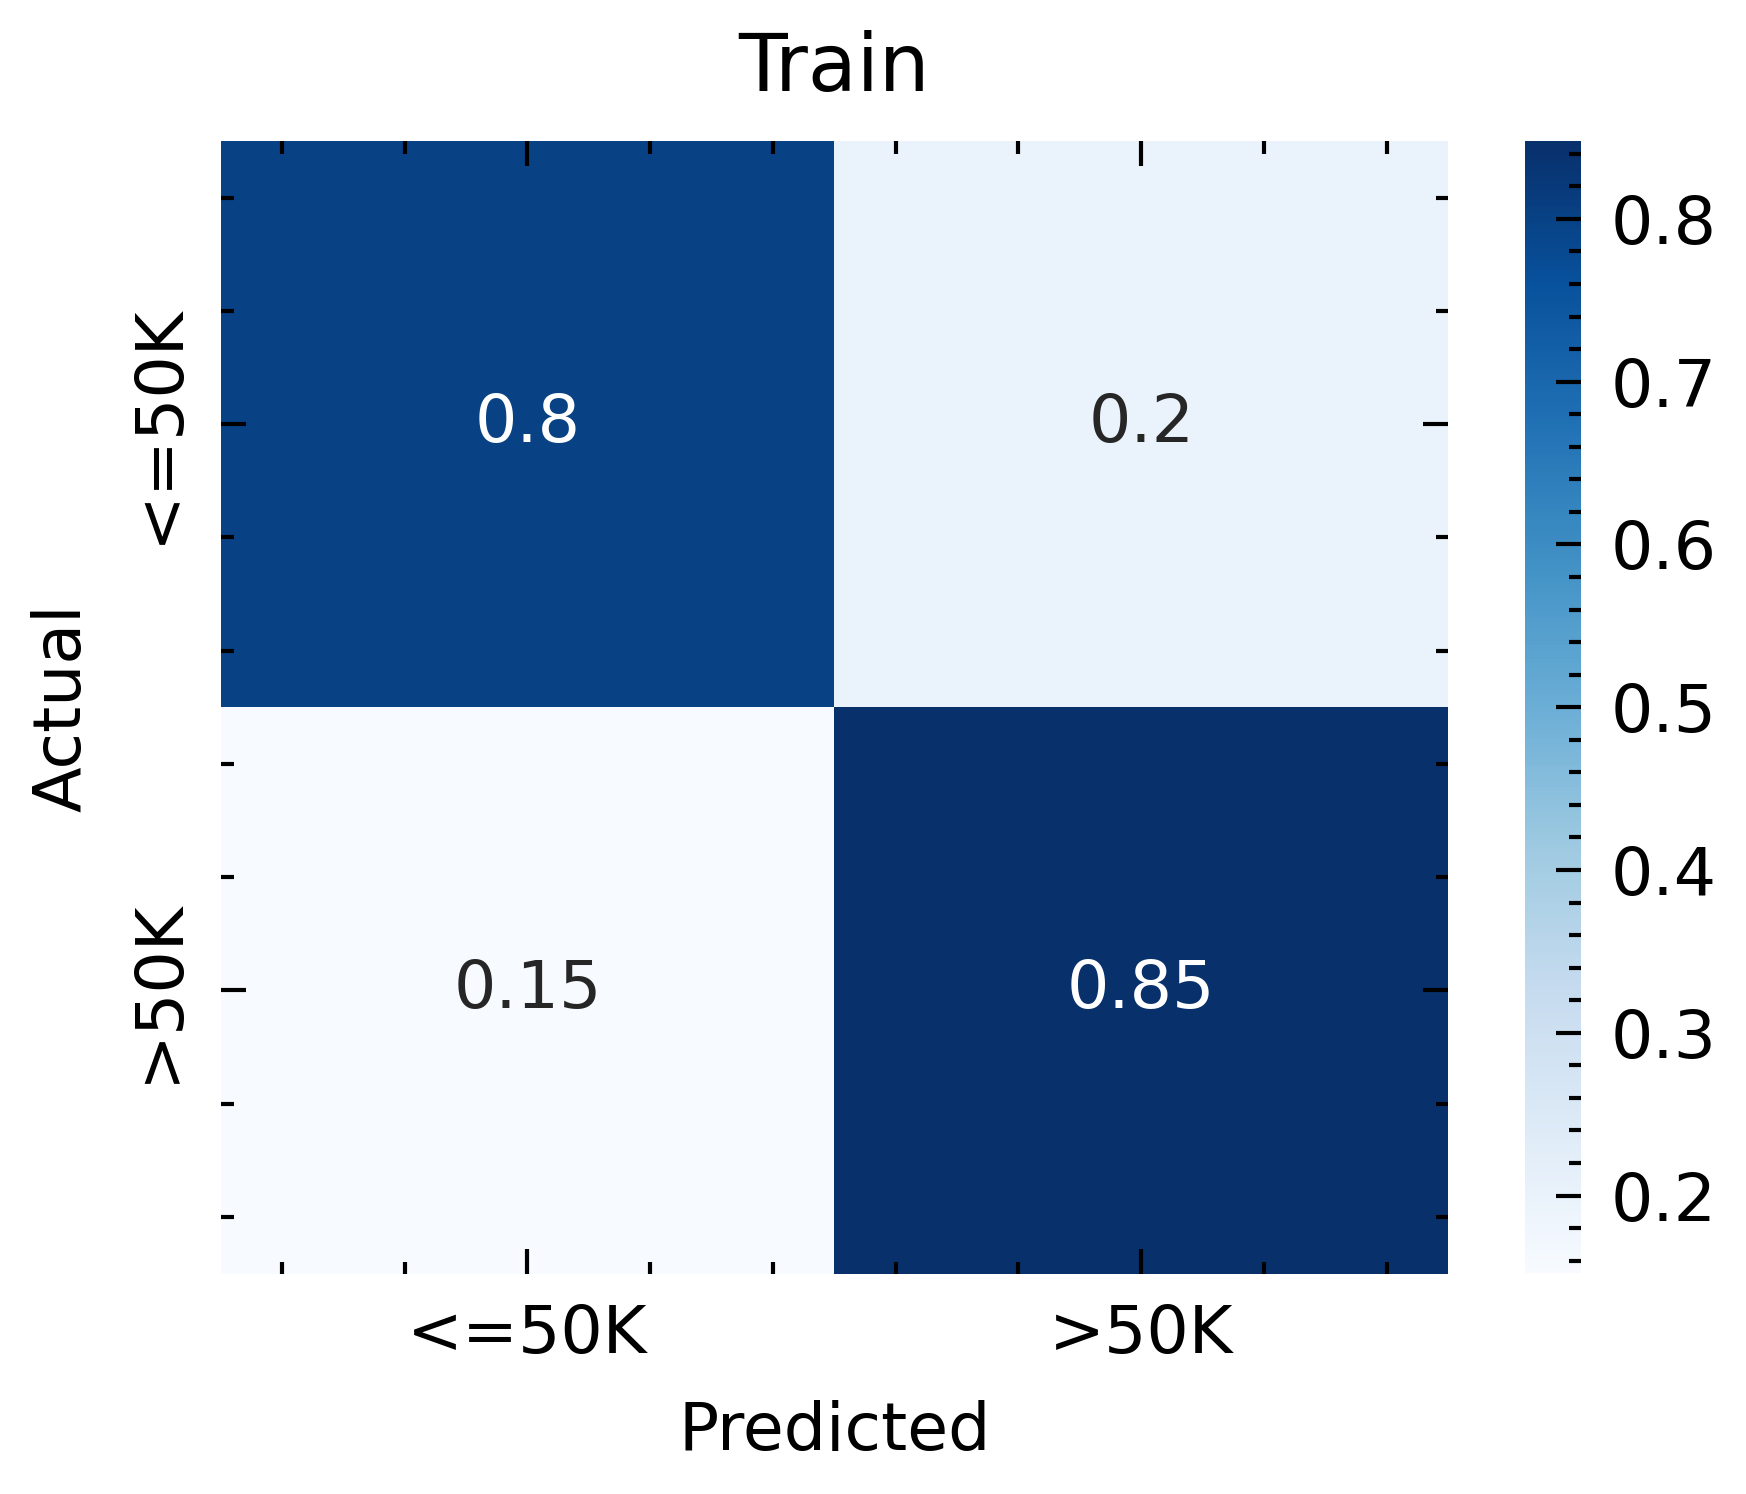

In [54]:
plotConfusionMatrix(YTrain, YTrainPred, labels=['<=50K', '>50K'], title='Train', savePath='figures/LogisticRegression/TrainConfusionMatrix.png')

# Looking at Search for Best Performing Number of Dims

In [37]:
# get dataframe of cv results from last search (Last Run)
bestResults = pd.DataFrame(pd.read_pickle('data/logistic_results.pkl').iloc[-1].cvResults)
bestResults = bestResults[['param_C', 'param_penalty', 'param_l1_ratio', 'mean_test_recall', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_precision', 'mean_test_roc_auc']]
bestResults

,param_C,param_penalty,param_l1_ratio,mean_test_recall,mean_test_accuracy,mean_test_f1,mean_test_precision,mean_test_roc_auc
0,100.0,none,0.8,0.845811,0.822535,0.826516,0.808238,0.905808
1,0.1,none,0.8,0.845811,0.822535,0.826516,0.808238,0.905808
2,1000.0,elasticnet,1.0,0.845683,0.822471,0.826441,0.808214,0.905809
3,0.001,l1,0.6,0.848998,0.760681,0.780091,0.721548,0.820388
4,0.0001,none,0.2,0.845811,0.822535,0.826516,0.808238,0.905808
5,0.001,l1,0.3,0.848998,0.760553,0.780000,0.721391,0.820392
6,10000.0,l2,0.2,0.845811,0.822535,0.826516,0.808238,0.905808
7,10.0,l2,0.6,0.845556,0.822216,0.826212,0.807894,0.905922
8,0.0001,elasticnet,0.6,0.750000,0.500064,0.500028,0.375032,0.500000
9,10.0,l1,0.6,0.845811,0.822344,0.826358,0.807943,0.905879


In [55]:
stats = bestResults.groupby(['param_C', 'param_penalty', 'param_l1_ratio']).mean().sort_index()
stats.to_pickle('data/logistic_stats.pkl')
stats

mean_test_recall  mean_test_accuracy  \
param_C    param_penalty param_l1_ratio                                         
0.0001     elasticnet    0.6                     0.750000            0.500064   
           l1            0.1                     0.500000            0.500064   
           l2            0.8                     0.818007            0.769672   
           none          0.2                     0.845811            0.822535   
0.0010     l1            0.3                     0.848998            0.760553   
                         0.6                     0.848998            0.760681   
           l2            1.0                     0.833056            0.784147   
0.0100     elasticnet    0.4                     0.847214            0.800854   
                         0.6                     0.846066            0.799770   
                         0.7                     0.844663            0.798495   
           l1            0.0                     0.846831            0.797347   
           l2            0.0                     0.848743            0.809845   
           none          0.5                     0.845811            0.822535   
0.1000     l1            0.7                     0.844280            0.820813   
           none          0.8                     0.845811            0.822535   
1.0000     none          0.8                     0.845811            0.822535   
10.0000    elasticnet    0.8                     0.845683            0.822280   
           l1            0.6                     0.845811            0.822344   
           l2            0.6                     0.845556            0.822216   
                         0.7                     0.845556            0.822216   
                         1.0                     0.845556            0.822216   
           none          0.7                     0.845811            0.822535   
100.0000   none          0.4                     0.845811            0.822535   
                         0.8                     0.845811            0.822535   
                         0.9                     0.845811            0.822535   
1000.0000  elasticnet    1.0                     0.845683            0.822471   
10000.0000 elasticnet    0.4                     0.845811            0.822535   
           l1            1.0                     0.845811            0.822535   
           l2            0.2                     0.845811            0.822535   
                         0.8                     0.845811            0.822535   

                                         mean_test_f1  mean_test_precision  \
param_C    param_penalty param_l1_ratio                                      
0.0001     elasticnet    0.6                 0.500028             0.375032   
           l1            0.1                 0.333362             0.250032   
           l2            0.8                 0.780249             0.745891   
           none          0.2                 0.826516             0.808238   
0.0010     l1            0.3                 0.780000             0.721391   
                         0.6                 0.780091             0.721548   
           l2            1.0                 0.794166             0.758848   
0.0100     elasticnet    0.4                 0.809622             0.775314   
                         0.6                 0.808570             0.774335   
                         0.7                 0.807336             0.773237   
           l1            0.0                 0.806883             0.770567   
           l2            0.0                 0.816912             0.787532   
           none          0.5                 0.826516             0.808238   
0.1000     l1            0.7                 0.824865             0.806557   
           none          0.8                 0.826516             0.808238   
1.0000     none          0.8                 0.826516             0.808238   
10.0000    elasticnet    0.8                